In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import pystan

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

In [4]:
## load the data for each country
data = []
for country in ['france', 'us', 'uk', 'japan']:
    df = pd.read_csv('../data/idl_'+country+'.csv', sep=';')
    data.append(df)
data = pd.concat(data, axis=0)
data.head()

,Id,Age(years),Age(days since last birthday),Age(days),Sex,Country of birth,Country of death,Date of birth,Date of death,Validation
0,566,110,145,40321,F,FRA,FRA,25/06/1877,17/11/1987,A
1,567,111,286,40828,F,FRA,FRA,19/03/1879,30/12/1990,A
2,568,111,299,40840,F,FRA,FRA,12/02/1881,07/12/1992,A
3,569,110,53,40229,F,FRA,FRA,28/12/1881,19/02/1992,A
4,570,110,108,40285,F,FRA,FRA,18/04/1883,04/08/1993,A


In [37]:
data['yob'] = data['Date of birth'].apply(lambda x: pd.to_datetime(x).year)

In [49]:
data['yod'] = data['Date of death'].apply(lambda x: pd.to_datetime(x).year)

In [56]:
data['aod'] = data['Age(days)']/365.

(array([ 395.,   70.,   36.,   23.,    7.,    1.,    0.,    1.,    0.,    1.]),
 array([ 110. ,  111.2,  112.4,  113.6,  114.8,  116. ,  117.2,  118.4,
         119.6,  120.8,  122. ]),
 <a list of 10 Patch objects>)

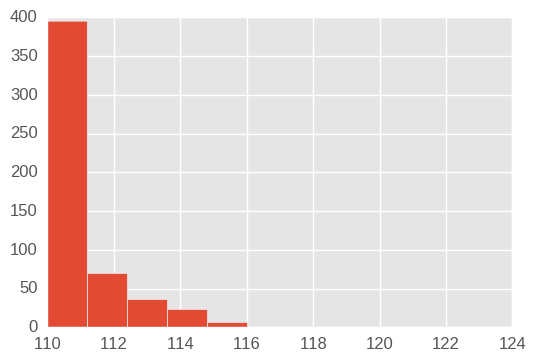

In [31]:
plt.hist(data['Age(years)'])

(array([ 293.,  146.,   52.,   32.,    8.,    0.,    1.,    1.,    0.,    1.]),
 array([ 110.07123288,  111.31726027,  112.56328767,  113.80931507,
         115.05534247,  116.30136986,  117.54739726,  118.79342466,
         120.03945205,  121.28547945,  122.53150685]),
 <a list of 10 Patch objects>)

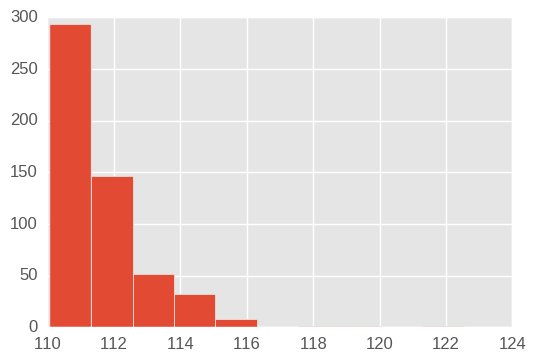

In [57]:
plt.hist(data.aod)

In [43]:
1./(data['Age(years)'].mean() - 109)

0.49674418604651183

In [54]:
((data.yod == 1970) & (data.yob == 1970)).sum()

341

In [55]:
data.loc[((data.yod == 1970) & (data.yob == 1970))].mean()

Id                                 395.000000
Age(years)                         110.961877
Age(days since last birthday)      164.642229
Age(days)                        40692.431085
yob                               1970.000000
yod                               1970.000000
dtype: float64

In [44]:
geom_p = 1./(data.groupby('yob')['Age(years)'].mean() - 109)

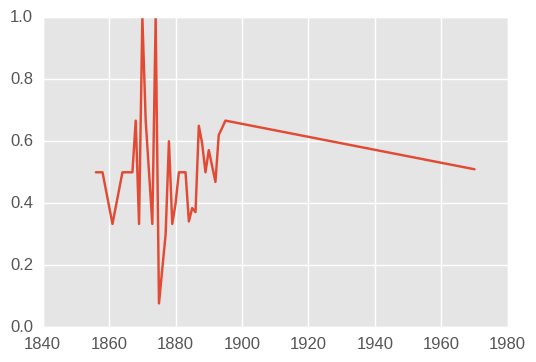

In [47]:
plt.plot(geom_p.index, geom_p)

## Model the lifespans as being generated from a beta distribution with an uknown upper bound

In [208]:
%%writefile 161222_stan_beta_bounded.stan

data{
    int <lower=0> N; //number of data points
    real <lower=0> age_at_death[N]; //ages at death
}

parameters{
    real<lower=max(age_at_death)> max_lifespan;
    real<lower=0> alpha;
    real<lower=0> beta;
}

transformed parameters{
    real<lower=0> age_transformed[N];
    for (i in 1:N){
        age_transformed[i] = age_at_death[i]/max_lifespan;
    }
}

model{
    //priors on parameters
    max_lifespan ~ exponential(1./15.); // give the prior a mean of 15 (125 because relative to 110)
    alpha ~ lognormal(0, 10);
    beta ~ lognormal(0, 10);
    
    // model of age at death
    // increment directly to ensure constants are preserved
    age_transformed ~ beta(alpha, beta);
}


Overwriting 161222_stan_beta_bounded.stan


In [209]:
## compile the stan model
model_beta = pystan.StanModel(file='161222_stan_beta_bounded.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_348b8f8ed25be58279fb59f62c8fe69b NOW.


In [210]:
model_data = {
    'N': len(data)
    , 'age_at_death': data.aod - 110
}

In [211]:
fit_beta = model_beta.sampling(model_data, chains=1, iter=10000)

In [212]:
keys = ['max_lifespan', 'alpha', 'beta', 'lp__']
samples = pd.DataFrame({k:fit_beta[k] for k in keys})
samples.describe()

,alpha,beta,lp__,max_lifespan
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.284837,6696.358679,3519.385405,8021.277827
std,0.067407,511.593672,1.154188,327.071826
min,1.087526,5045.595908,3510.730332,6871.766287
25%,1.240559,6338.558912,3518.867865,7795.000203
50%,1.284533,6685.901279,3519.691657,8018.775300
75%,1.329170,7030.997180,3520.211173,8243.573853
max,1.570247,9019.655003,3520.768418,9160.073310


The posterior over the maximum lifespan shows that under this model there is not a meaningful upper limit.

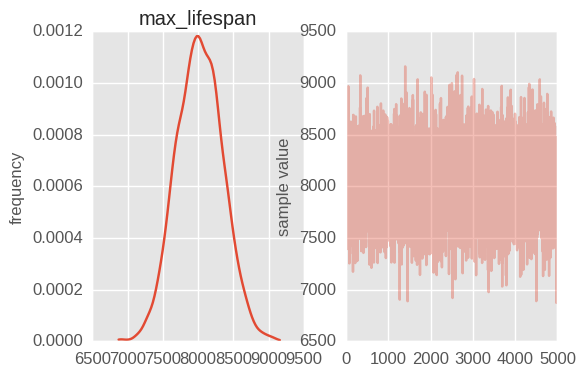

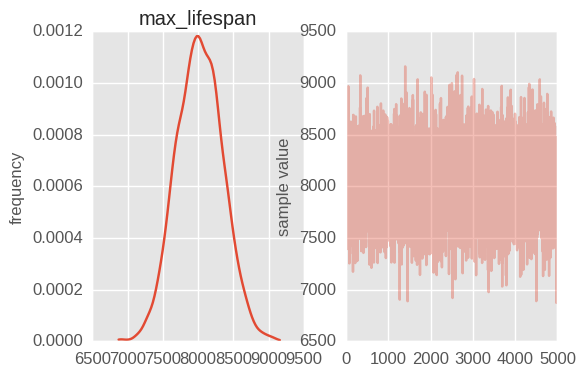

In [213]:
fit_beta.traceplot('max_lifespan')

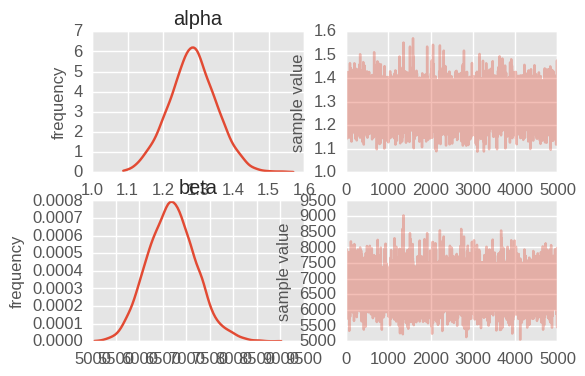

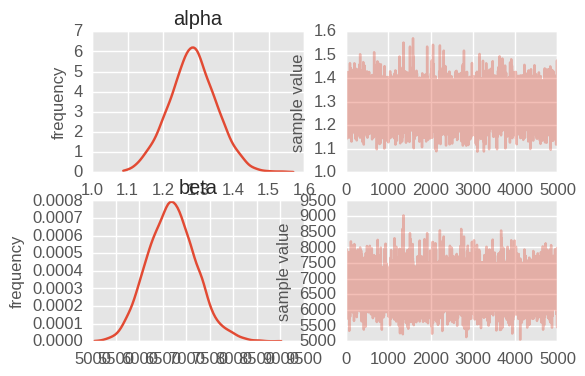

In [214]:
fit_beta.traceplot(['alpha', 'beta'])

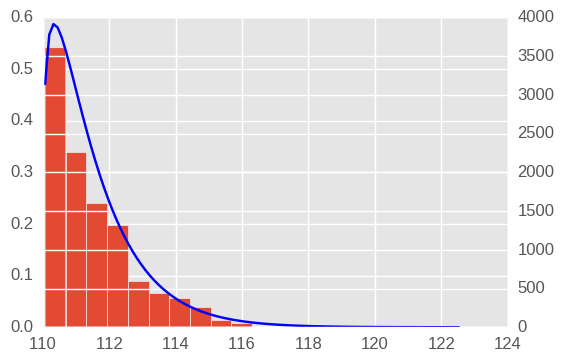

In [351]:
import scipy.stats
x = np.linspace(data.aod.min()-110, data.aod.max()-110, 100)/fit_beta['max_lifespan'].mean()
curve = scipy.stats.beta.pdf(x, fit_beta['alpha'].mean(), fit_beta['beta'].mean())
ax = plt.gca()
ax.hist(data.aod, normed=True, bins=20)
ax.twinx().plot((x*fit_beta['max_lifespan'].mean())+110, curve, color='blue')

## Poisson model as used in the paper

In [215]:
%%writefile 161222_stan_poisson.stan

data{
    int <lower=0> N; //number of data points
    int <lower=0> age_at_death[N]; //ages at death
}

parameters{
    real<lower=0> lambda;
}

model{
    //priors on parameters
    lambda ~ lognormal(0, 10);
    
    // model of age at death
    age_at_death ~ poisson(lambda);
}


Overwriting 161222_stan_poisson.stan


In [216]:
## compile the stan model
model_poisson = pystan.StanModel(file='161222_stan_poisson.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1afe40e719e2c3519c249dd0d2aef441 NOW.


In [217]:
model_data = {
    'N': len(data)
    , 'age_at_death': data['Age(years)'] - 110
}

In [218]:
fit_poisson = model_poisson.sampling(model_data, chains=1, iter=10000)

In [219]:
fit_poisson

Inference for Stan model: anon_model_1afe40e719e2c3519c249dd0d2aef441.
1 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda   1.01  7.7e-4   0.04   0.93   0.99   1.01   1.04   1.09 2731.0    1.0
lp__   -534.3    0.01   0.67 -536.4 -534.5 -534.1 -533.9 -533.9 2048.0    1.0

Samples were drawn using NUTS at Fri Dec 23 00:20:04 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

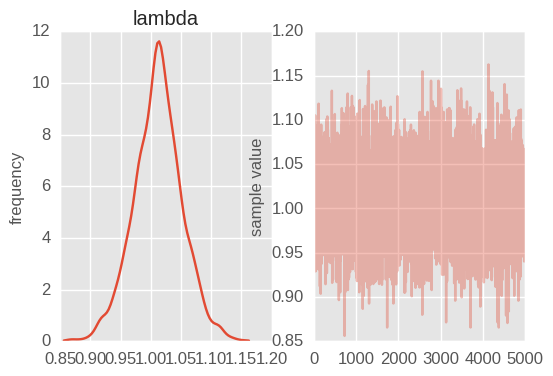

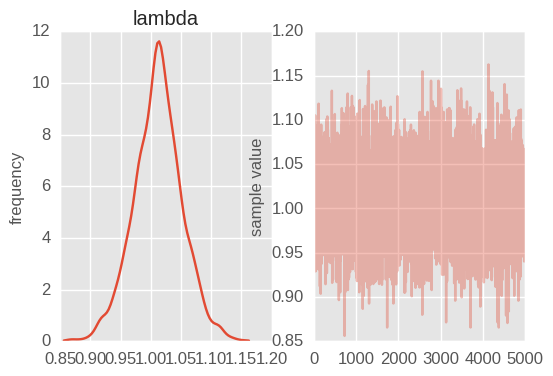

In [220]:
fit_poisson.traceplot()

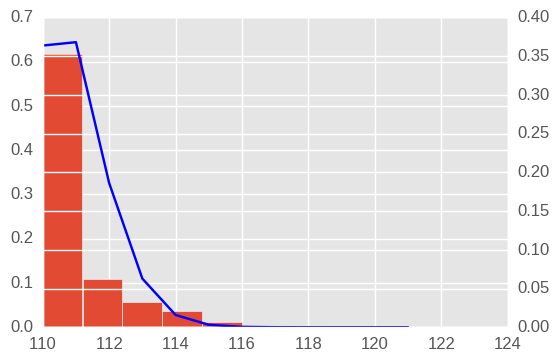

In [354]:
x = np.arange(0, data['Age(years)'].max()-110)
curve = scipy.stats.poisson.pmf(x, fit_poisson['lambda'].mean())
ax = plt.gca()
ax.hist(data['Age(years)'], normed=True)
ax.twinx().plot(x+110, curve, color='blue')

## Mixture of the poisson and beta models for model comparison

In [326]:
%%writefile 161222_stan_mixture.stan

data{
    int <lower=0> N; //number of data points
    real <lower=0> age_at_death_real[N]; //ages at death
    int <lower=0> age_at_death_int[N];
}

parameters{
    //beta dist params
    real<lower=max(age_at_death_real)> max_lifespan;
    real<lower=0> alpha;
    real<lower=0> beta;
    
    //poisson dist params
    real<lower=0> lambda;
    
    //mixture params
    real<lower=0,upper=1> mix;
}

transformed parameters{
    real<lower=0> age_transformed[N];
    for (i in 1:N){
        age_transformed[i] = age_at_death_real[i]/max_lifespan;
    }
}

model{
        
    vector[2] log_ps;
    
    //priors on parameters
    max_lifespan ~ exponential(1./15.); // give the prior a mean of 15 (125 because relative to 110)
    alpha ~ lognormal(0, 10);
    beta ~ lognormal(0, 10);
    
    lambda ~ lognormal(0, 10);
    
    mix ~ beta(1, 1); //use a totally uninformative prior on the mixing parameter
    
    // model of age at death
    // increment directly to ensure constants are preserved
    
    // both models should fit the data
    age_transformed ~ beta(alpha, beta);
    age_at_death_int ~ poisson(lambda);

    // infer the mixing parameter for model comparison
    log_ps[1] = log(mix) + beta_lpdf(age_transformed | alpha, beta);
    log_ps[2] = log(1-mix) + poisson_lpmf(age_at_death_int | lambda);
    
    increment_log_prob(log_sum_exp(log_ps));
    
}

Overwriting 161222_stan_mixture.stan


In [327]:
## compile the stan model
model_mixture = pystan.StanModel(file='161222_stan_mixture.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_79147b83705e0431af79b917a153af65 NOW.


In [328]:
model_data = {
    'N': len(data)
    , 'age_at_death_int': data['Age(years)'] - 110
    , 'age_at_death_real': data.aod - 110
}

In [329]:
fit_mixture = model_mixture.sampling(model_data, chains=4, iter=20000)

In [330]:
keys = ['max_lifespan', 'alpha', 'beta', 'lambda', 'mix', 'lp__']
samples = pd.DataFrame({k:fit_mixture[k] for k in keys})
samples.describe()

,alpha,beta,lambda,lp__,max_lifespan,mix
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,1.288380,13439.899249,1.013205,7235.577267,16036.509724,0.670467
std,0.048397,733.414079,0.041741,1.557060,471.119050,0.228147
min,1.074465,10687.311813,0.847435,7223.031002,14053.413973,0.003800
25%,1.255526,12940.445684,0.984697,7234.787841,15720.090983,0.509756
50%,1.287607,13426.308054,1.012560,7235.901390,16034.602902,0.709289
75%,1.320518,13921.591691,1.040846,7236.713230,16346.618125,0.861962
max,1.508415,16903.758361,1.221757,7237.966191,18474.521047,0.999966


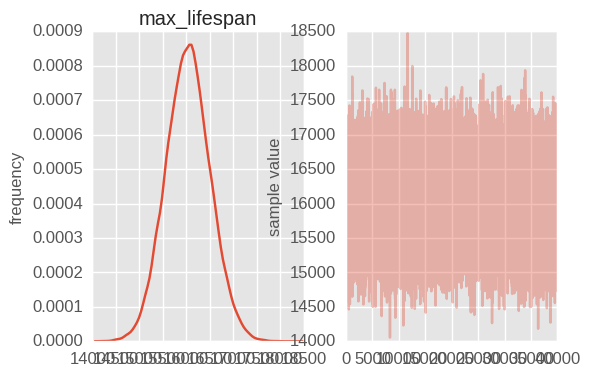

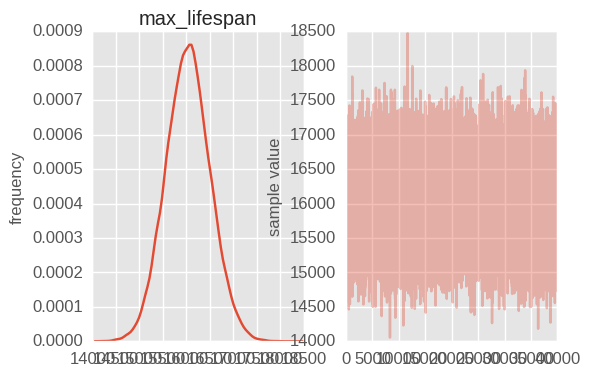

In [331]:
fit_mixture.traceplot('max_lifespan')

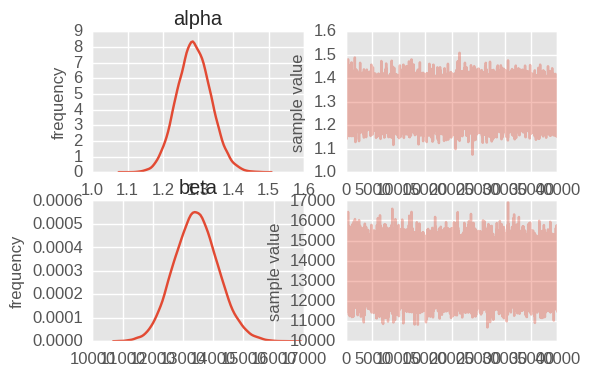

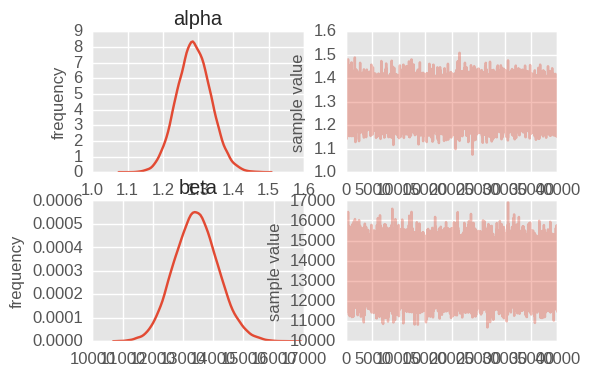

In [332]:
fit_mixture.traceplot(['alpha', 'beta'])

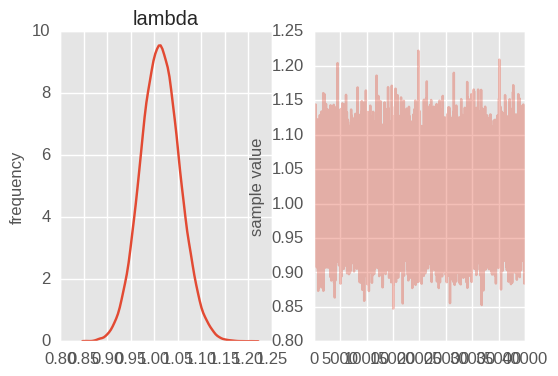

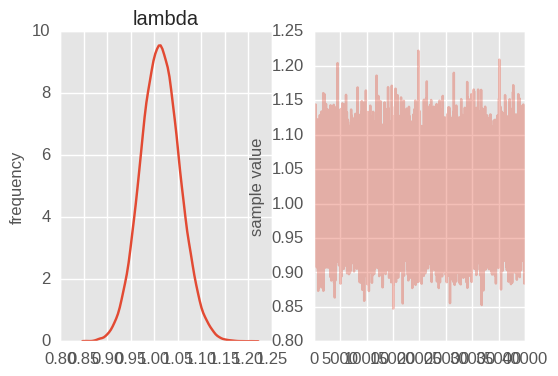

In [333]:
fit_mixture.traceplot('lambda')

The mixing parameter favors the beta model.

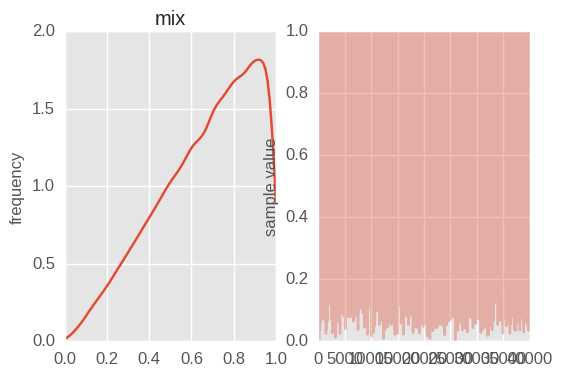

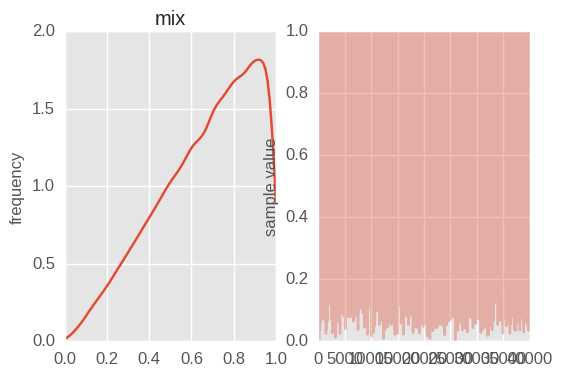

In [334]:
fit_mixture.traceplot('mix')

## Now try a mixture of gamma and beta with random upper bound models
Try a gamma distribution on the lifespans to see if a model without an upper bound but on the real numbers performs better

In [316]:
%%writefile 161222_stan_mixture2.stan

data{
    int <lower=0> N; //number of data points
    real <lower=0> age_at_death[N]; //ages at death
}

parameters{
    //beta dist params
    real<lower=max(age_at_death)> max_lifespan;
    real<lower=0> alpha[2];
    real<lower=0> beta[2];
    
    //mixture params
    real<lower=0,upper=1> mix;
}

transformed parameters{
    real<lower=0> age_transformed[N];
    for (i in 1:N){
        age_transformed[i] = age_at_death[i]/max_lifespan;
    }
}

model{
        
    vector[2] log_ps;
    
    //priors on parameters
    max_lifespan ~ exponential(1./15.); // give the prior a mean of 15 (125 because relative to 110)
    alpha ~ lognormal(0, 10);
    beta ~ lognormal(0, 10);
    
    mix ~ beta(1, 1); //use a totally uninformative prior on the mixing parameter
    
    // model of age at death
    // increment directly to ensure constants are preserved
    
    // both models should fit the data
    age_transformed ~ beta(alpha[1], beta[1]);
    age_at_death ~ gamma(alpha[2], beta[2]);
    
    // infer the mixing parameter for model selection
    log_ps[1] = log(mix) + beta_lpdf(age_transformed | alpha[1], beta[1]);
    log_ps[2] = log(1-mix) + gamma_lpdf(age_at_death | alpha[2], beta[2]);
    
    increment_log_prob(log_sum_exp(log_ps));
    
}

Overwriting 161222_stan_mixture2.stan


In [317]:
## compile the stan model
model_mixture2 = pystan.StanModel(file='161222_stan_mixture2.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e981d063218736f4379136a493ed22e1 NOW.


In [318]:
model_data = {
    'N': len(data)
    , 'age_at_death': data.aod - 110
}

In [319]:
fit_mixture2 = model_mixture2.sampling(model_data, chains=12, iter=20000)

In [321]:
keys = ['max_lifespan', 'alpha', 'beta', 'mix', 'lp__']
samples = pd.concat({k:pd.DataFrame(fit_mixture2[k]) for k in keys}, axis=1)
samples.describe()

alpha                          beta                 \
                   0              1              0              1   
count  120000.000000  120000.000000  120000.000000  120000.000000   
mean        1.288311       1.287493   13433.979466       0.837600   
std         0.047819       0.067580     725.036549       0.053498   
min         1.095885       1.018955   10600.551393       0.621601   
25%         1.255895       1.241559   12935.135791       0.801164   
50%         1.287711       1.286312   13419.287425       0.836562   
75%         1.319990       1.332173   13913.632801       0.872918   
max         1.492309       1.627179   17128.441008       1.095689   

                lp__   max_lifespan            mix  
                   0              0              0  
count  120000.000000  120000.000000  120000.000000  
mean     7015.416331   16033.658166       0.669717  
std         1.684240     468.050424       0.229584  
min      6998.663809   13867.651149       0.003956  
25%      7014.537351   15719.129765       0.509504  
50%      7015.739586   16029.157515       0.708409  
75%      7016.648988   16342.567530       0.861902  
max      7018.253412   18166.962191       1.000000

Interstingly, the beta distributed lifespan model with maximum lifespan parameter performs better then the unbounded gamma distributed model. Perhaps there is some other aspect of the beta distribution that allows it to fit the observed lifespans better.

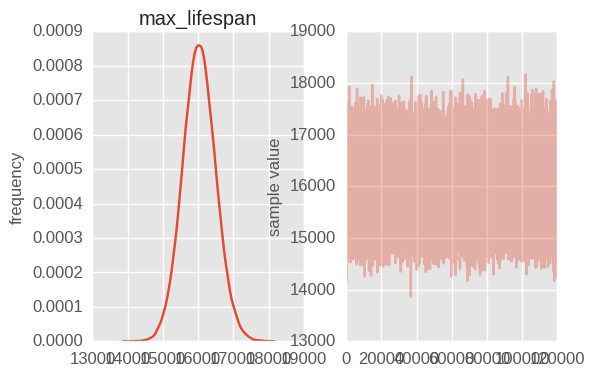

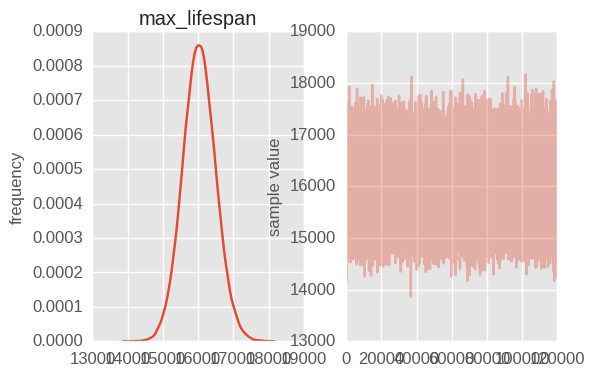

In [322]:
fit_mixture2.traceplot('max_lifespan')

In [323]:
to_plot = samples[['alpha', 'beta']].stack().stack()
to_plot = pd.DataFrame(to_plot).reset_index([1,2])
to_plot.columns = ['Model', 'Parameter', 'Value']
#to_plot.head()

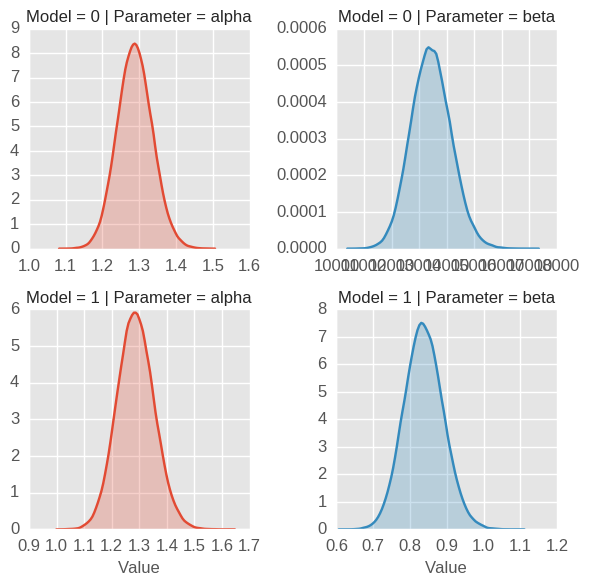

In [324]:
g = sns.FacetGrid(to_plot, row='Model', col='Parameter', hue='Parameter', sharex=False, sharey=False)
g.map(sns.kdeplot, 'Value', shade=True)

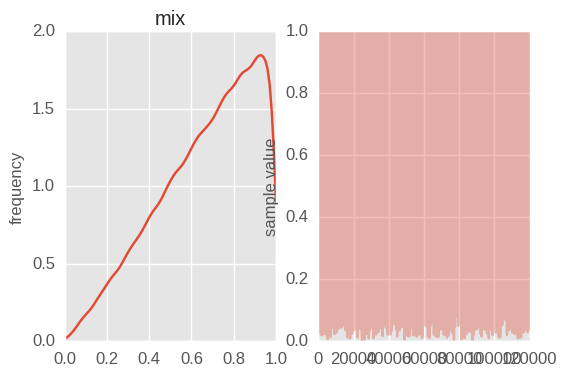

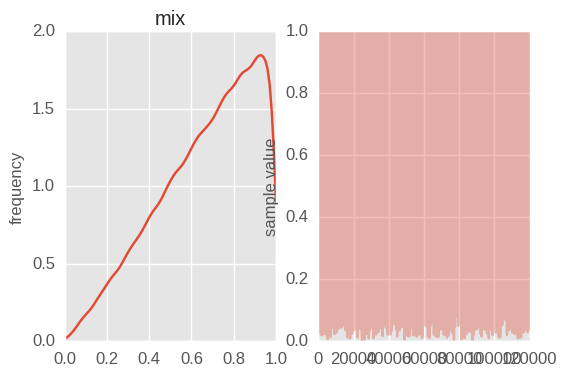

In [373]:
fit_mixture2.traceplot('mix')

The beta and gamma distributions seem to overlap perfectly. Weird that the model seems to prefer the beta distribution so strongly from the mixing parameter?

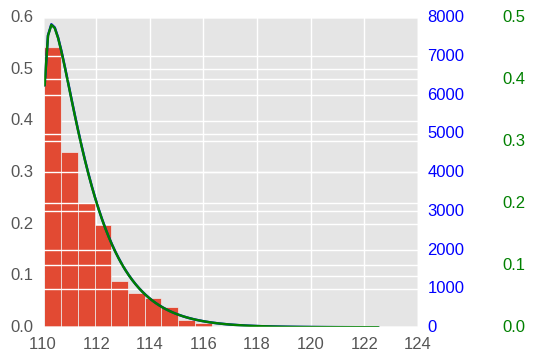

In [372]:

x = np.linspace(data.aod.min()-110, data.aod.max()-110, 100)/fit_mixture2['max_lifespan'].mean()
x2 = np.linspace(data.aod.min()-110, data.aod.max()-110, 100)
curve = scipy.stats.beta.pdf(x, fit_mixture2['alpha'][:,0].mean(), fit_mixture2['beta'][:,0].mean())
gamma_alpha = fit_mixture2['alpha'][:,1].mean()
gamma_scale = 1./fit_mixture2['beta'][:,1].mean()
curv2 = scipy.stats.gamma.pdf(x2, gamma_alpha, scale=gamma_scale)

fig, ax = plt.subplots()
axes = [ax, ax.twinx(), ax.twinx()]
# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)
# Move the last y-axis spine over to the right by 20% of the width of the axes
axes[-1].spines['right'].set_position(('axes', 1.2))
# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)

axes[0].hist(data.aod, normed=True, bins=20)
axes[1].plot((x*fit_mixture2['max_lifespan'].mean())+110, curve, color='blue')
axes[1].tick_params(axis='y', colors='blue')
axes[2].plot((x*fit_mixture2['max_lifespan'].mean())+110, curv2, color='green')
axes[2].tick_params(axis='y', colors='green')